# Introduction

In this project, we estimate the variance risk premium (VRP) of the Standard & Poor’s 500 (SPX) index in November. This estimation is conducted as if we were on the first day of November ($t$), and we need to decide whether we should sell variance swaps.

The variance risk premium represents the premium associated with the variance risk. Its negative value in the U.S. market is a well-documented phenomenon in the literature, suggesting that investors are willing to pay for insurance against unexpected increases in volatility. In other words, the (opposite of) VRP reflects the expected compensation for selling variance swaps.

The monthly variance risk premium (over approximately 21 trading days) is defined as the difference between the objective and risk-neutral conditional expectation of the monthly realized variance of stock returns for that period:
\begin{equation}
VRP_{1M} = E_{t}^{P}[RV_{1M}] - E_{t}^{Q}[RV_{1M}],
\end{equation}
in which $RV_{21}$ is the annualized monthly realized variance of SPX log-return measured as the sum of squared daily returns over the next month.

- To approximate $E_{t}^{Q}[RV_{1M}]$, we use the square of the Volatility Index (VIX), denoted as $VIX^2$, as reported by the Chicago Board Options Exchange (CBOE). This choice is based on the fact that the $VIX^2$ represents the expected realized variance (under $Q$) of S&P 500 returns over the following month.

- For estimating $E_{t}^{P}[RV_{1M}]$, we use three different models:
1.  Linear Regression (LR)
2.  Decision Tree Regression (DTR)
3.  Multilayer perceptron (MLP)

## Libraries to import

In [ ]:
import random
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import networkx as nx

from copy import deepcopy
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.linear_model import LinearRegression

# Get Data from Yahoo Finance

From Yahoo Finance, we downloaded the daily levels of the SPX index since they are available until October 31 and the level of the VIX on the first day of November

In [ ]:
# Download S&P500 and VIX data
close_SPX = yf.download("^GSPC", start="1928-01-01", end="2024-10-31")["Close"] # For download daily closing prices of S&P 500 (^GSPC) from January 1928 to October 31 2024
close_VIX = (yf.download("^VIX", start="2024-11-01", end="2024-11-02")["Close"])/100 # To download the first observation of the VIX in the month of November.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Data manipulation


We verified that there are no missing data

In [ ]:
close_SPX.info() # check if there are non null

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24324 entries, 1928-01-03 00:00:00+00:00 to 2024-10-30 00:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ^GSPC   24324 non-null  float64
dtypes: float64(1)
memory usage: 380.1 KB


### SPX Manipulation

Calculating daily squared log returns as: $ r_t^2 = (ln(S_{t}) - ln(S_{t-1}))^2$

In [ ]:
close_SPX["log_ret"] = np.log(close_SPX).diff() # for calculating the log returns
close_SPX["squared_log_ret"] = close_SPX["log_ret"] ** 2 # to take the squared log returns

Calculating the Annualized Monthly Realized Variance as: $
RV_{1M} = 12 \cdot \sum_{i} r_i^2 $

In [ ]:
monthly_RV = close_SPX["squared_log_ret"].resample("ME").sum() * 12 # for calculating the Annualized Realized Variance in each month as the sum of the squared returns in each month

monthly_RV_array = monthly_RV.values  # Extract the values as a NumPy array
dates = monthly_RV.index.date         # Get only the dates (index)

### Create time lags

In [ ]:
def create_lags_array(data, lags):
    """
    This function take the time series called data and the integer value of lags
    and create time windows of the time series dividing the as:
      - datas: the values of t-lags to t-1 as matrix (len(data)-lags, lags)
      - target: the value at time t to predict
    """
    index_target = np.arange(lags, len(data))
    targets = data[index_target]
    datas = np.array([data[i - lags : i] for i in index_target]).reshape(
        (len(data) - lags, lags)
    )
    return datas, targets

# Parameters for time series forecasting

The following parameters once set remain the same for all three models.

Notice that, to avoid possible issues, we do NOT shuffle the train set and the test since this would mean break the continuity of the time series and replicate as much as possible the reality context.

In [ ]:
test_size = 0.2
n_splits = 5
min_lags = 1
max_lags = 5
lags_list = np.arange(min_lags, max_lags+1)
shuffle = False

#  First Model : Linear Regression

The first model is a linear regression model, based on the assumption of a linear relationship in the variance data. While we recognize that certain statistical requirements are necessary to apply this type of model with an OLS estimator — such as normally distributed errors, homoscedasticity, independence of errors, and absence of multicollinearity ... — our focus here is on implementing the simplest model. Beyond the theoretical requirements, our primary objective is to analyze the results produced by this straightforward approach.

1) We perform a regression model with different lags:
$$ y_t = \alpha_0 + \sum_{i=1}^{p} \alpha_i y_{t-i} + \epsilon_t $$

2) To evaluate the model's ability to predict future data based on past values, we use Time series cross-validation

3) In the final step, the dataset is divided into training and test sets. The model is trained on the training set, and its performance is measured on the test set

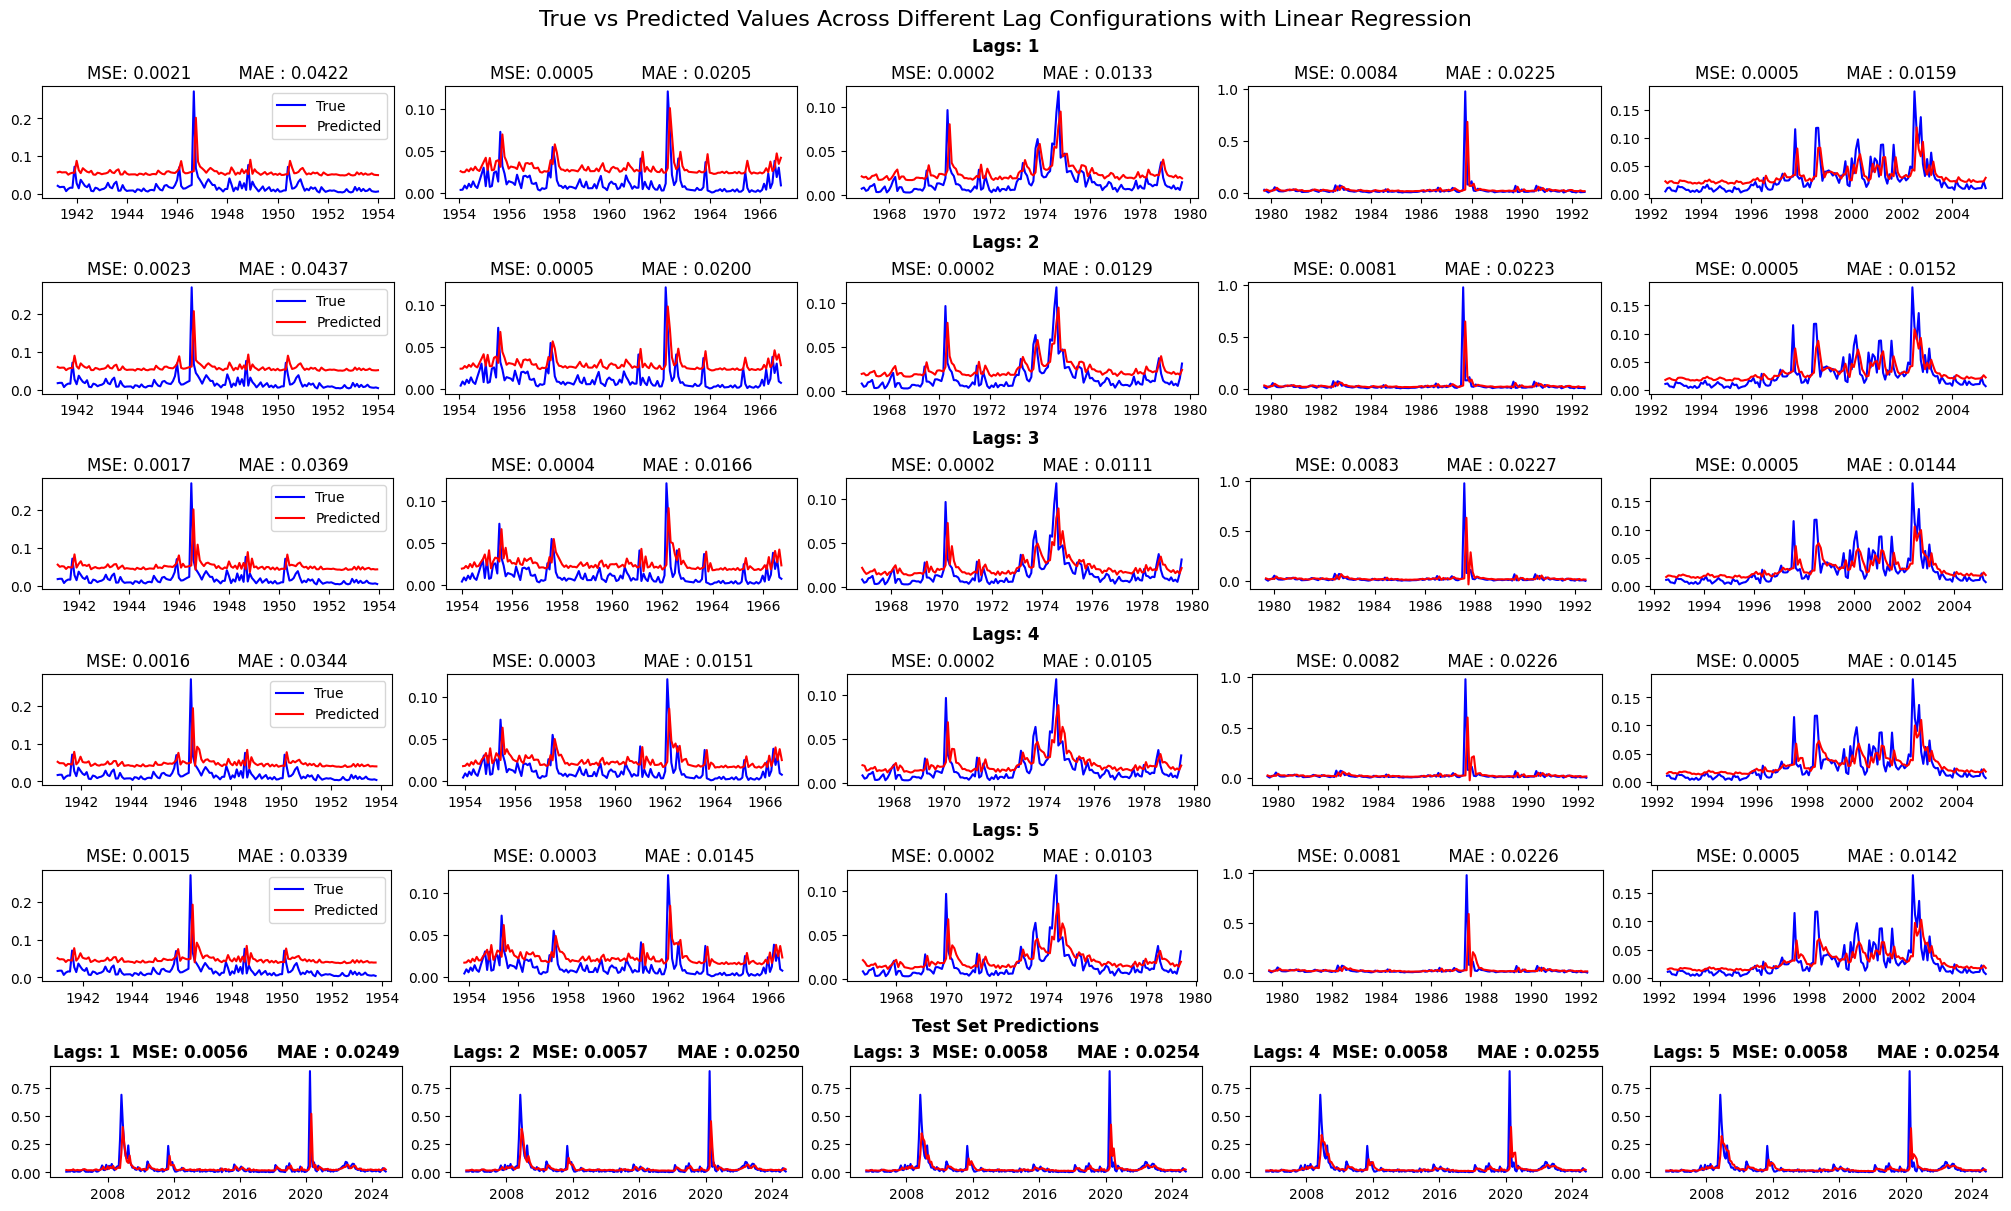

In [ ]:
# Initialize model
clf = LinearRegression()

# Create a plot
fig = plt.figure(constrained_layout=True, figsize=(20, 12))
fig.suptitle('True vs Predicted Values Across Different Lag Configurations with Linear Regression', fontsize=16)

# Create subfigures for each lag configuration row (without the test set)
subfigs = fig.subfigures(nrows=len(lags_list) + 1, ncols=1)  # +1 for the test set row

# Last row for test set
test_subfig = subfigs[-1]
test_subfig.suptitle("Test Set Predictions", fontsize=12, fontweight='bold')
test_axs = test_subfig.subplots(nrows=1, ncols=len(lags_list))

# Loop over lag configurations, creating one row per lag configuration for cross-validation folds
for row, (lags, subfig) in enumerate(zip(lags_list, subfigs[:-1])):
    subfig.suptitle(f'Lags: {lags}', fontsize=12, fontweight='bold')


    X, y = create_lags_array(monthly_RV_array, lags)
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=shuffle)
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Create subplots for each cross-validation split within the subfigure
    axs = subfig.subplots(nrows=1, ncols=n_splits)
    for i, (train, val) in enumerate(tscv.split(train_X)):
        clf.fit(train_X[train, :], train_y[train]) # It uses as indices those defined by train
        y_predict = clf.predict(train_X[val]) # It uses as indices those defined by val

        # Plot true vs predicted values for each validation fold
        axs[i].plot(dates[val], train_y[val], color="blue", label="True")
        axs[i].plot(dates[val], y_predict, color="red", label="Predicted")
        axs[i].set_title(f'MSE: {mean_squared_error(y_predict, train_y[val]):.4f} \
        MAE : {mean_absolute_error(y_predict, train_y[val]):.4f}')

        # Only add legend once per row
        if i == 0:
            axs[i].legend()
    # Train and predict on the entire training data
    clf.fit(train_X, train_y)
    y_predict = clf.predict(test_X)

    # Plot true vs predicted values for the test set and add it on the last row
    test_axs[row].plot(dates[-len(test_X):], test_y, color="blue", label="True")
    test_axs[row].plot(dates[-len(test_X):], y_predict, color="red", label="Predicted")
    test_axs[row].set_title(f'Lags: {lags}  MSE: {mean_squared_error(y_predict, test_y):.4f} \
    MAE : {mean_absolute_error(y_predict, test_y):.4f}', fontweight='bold')

plt.show()


Results: <br>
- From a qualitative perspective, as more lags are included, the model appears to become less responsive. This reduced responsiveness is due to the lags, which slow the model’s reaction to changes. With fewer lags, the model tends to be more sensitive to unexpected spikes in the data.<br>
- From a quantitative perspective, the Mean Squared Error (MSE) generally tends to be very low, largely because of the data's scale. The Mean Absolute Error (MAE), which is somewhat more robust to scale differences, aligns with the trends shown by the MSE.


# Second model: Decision Tree Regressor

Now that a simple linear regresion model has been investigated the following question arised: it is possible that the datas presents some kind of non-linearity to improve the predictions?

During our lessons we have seen the Decision Tree to classify results for possible non-linear data, but they can also be used for regression purposes with trivial changes.

The main differences with a Decision Tree Classifier are the followings:

1.   The function used to decide the splitting condition is based on the reduction of a metric function, in our case we used the MSE.
2.   The value predicted will be the mean of the values of the samples found in the region defined by the splitting criterion.

The training, validation and testing will be exactly the same of the Linear Regression with both MSE and MAE metrics and TimeSeries splitting to have a possible comparison in the same conditions.



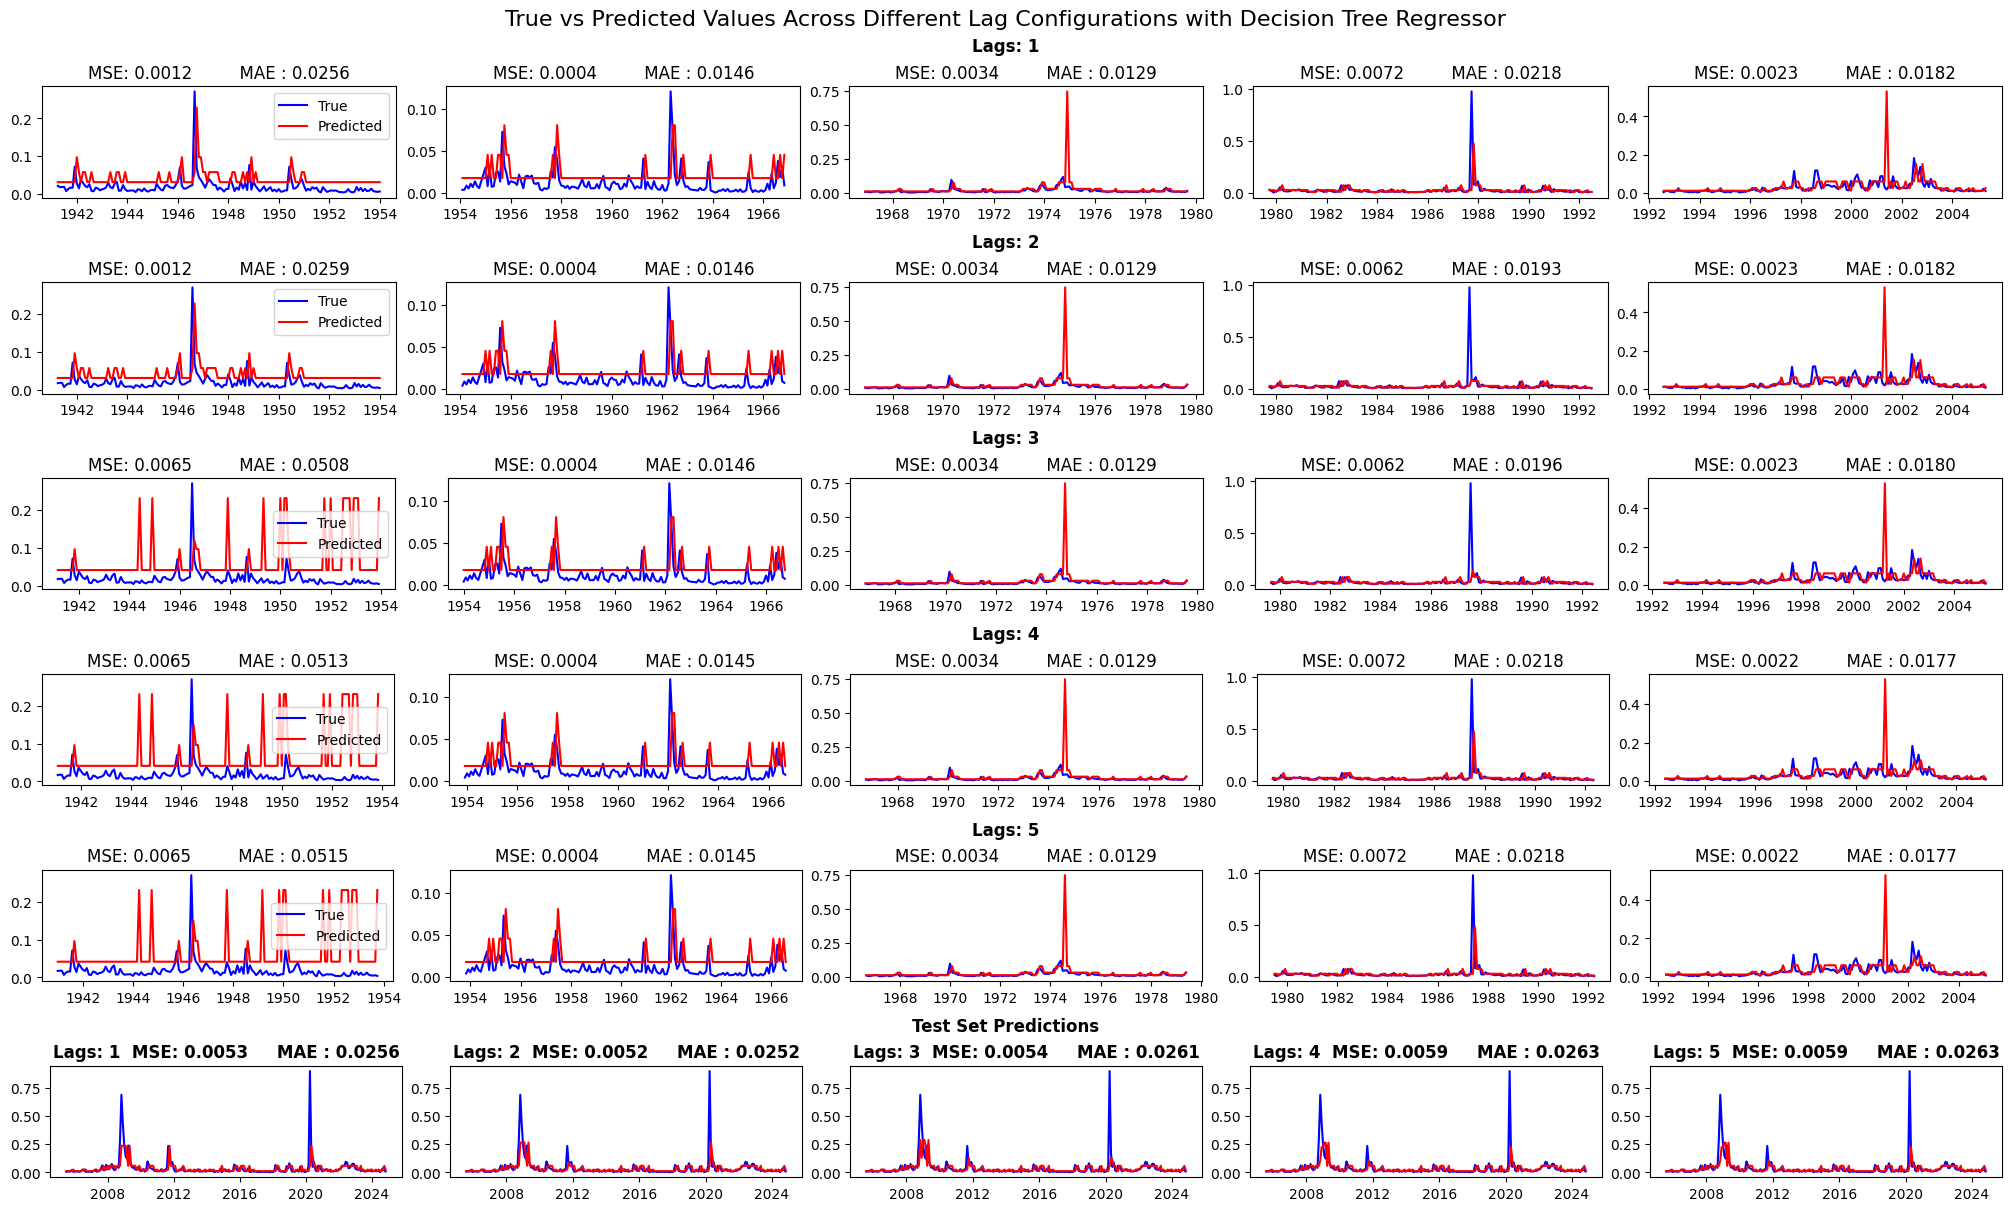

In [ ]:
#early stopping with max_depth in order to avoid overfitting
tree_regressor = DecisionTreeRegressor(max_depth = 3)

fig = plt.figure(constrained_layout=True, figsize=(20, 12))
fig.suptitle('True vs Predicted Values Across Different Lag Configurations with Decision Tree Regressor', fontsize=16)

# Create subfigures for each lag configuration row (without the test set)
subfigs = fig.subfigures(nrows=len(lags_list) + 1, ncols=1)  # +1 for the test set row

test_subfig = subfigs[-1]
test_subfig.suptitle("Test Set Predictions", fontsize=12, fontweight='bold')
test_axs = test_subfig.subplots(nrows=1, ncols=len(lags_list))

# Loop over lag configurations, creating one row per lag configuration for cross-validation folds
for row, (lags, subfig) in enumerate(zip(lags_list, subfigs[:-1])):
    subfig.suptitle(f'Lags: {lags}', fontsize=12, fontweight='bold')

    X, y = create_lags_array(monthly_RV_array, lags)
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=shuffle)
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Create subplots for each cross-validation split within the subfigure
    axs = subfig.subplots(nrows=1, ncols=n_splits)
    for i, (train, val) in enumerate(tscv.split(train_X)):
        tree_regressor.fit(train_X[train, :], train_y[train])
        y_predict = tree_regressor.predict(train_X[val])

        # Plot true vs predicted values for each validation fold
        axs[i].plot(dates[val], train_y[val], color="blue", label="True")
        axs[i].plot(dates[val], y_predict, color="red", label="Predicted")
        axs[i].set_title(f'MSE: {mean_squared_error(y_predict, train_y[val]):.4f} \
        MAE : {mean_absolute_error(y_predict, train_y[val]):.4f}')

        # Only add legend once per row
        if i == 0:
            axs[i].legend()
    # Train and predict on the entire training data
    tree_regressor.fit(train_X, train_y)
    y_predict = tree_regressor.predict(test_X)

    # Plot true vs predicted values for the test set and add it on the last row
    test_axs[row].plot(dates[-len(test_X):], test_y, color="blue", label="True")
    test_axs[row].plot(dates[-len(test_X):], y_predict, color="red", label="Predicted")
    test_axs[row].set_title(f'Lags: {lags}  MSE: {mean_squared_error(y_predict, test_y):.4f} \
    MAE : {mean_absolute_error(y_predict, test_y):.4f}', fontweight='bold')

plt.show()

Results:

- From a qualitative perspective it seems that the decision is not able to exactly predict the possible spikes this may due to the fact that the predicted values are the mean of the values seen in the training phase and they may not be so high. Furthermore it seems more sensible to small variations in the first folds compared to lineare regression.
- From a quantitative perspective, the MSE generally tends to be very low, lower or equal than the linear regression. The MAE instead it is in many cases higher than the Linear Regression results.

# Multilayer Perceptron (MLP)
The last model we used is the Multilayer perceptron, that is a type of feedforward neural network consisting of fully connected neurons with a nonlinear kind of activation function.
In a multilayer perceptron, neurons process information in a step-by-step manner, performing computations that involve weighted sums and nonlinear transformations.
#### Input layer
The input layer of an MLP receives input data. Neurons in the input layer do not perform any computations; they simply pass the input values to the neurons in the first hidden layer.
#### Hidden layer
The hidden layers of an MLP consist of interconnected neurons that perform computations on the input data.
For each neuron in a hidden layer or the output layer, the weighted sum of its inputs is computed. This involves multiplying each input by its corresponding weight, summing up these products, and adding the bias.
$$
\text{Weighted Sum} = \sum_{i=1}^n (w_i \cdot x_i) + b
$$
Where $n$ is the total number of input connections, $w_i$ is the weight for the i-th input, and $x_i$ is the i-th input value.\
The weighted sum is then passed through an activation function, which introduces nonlinearity into the network.
#### Output layer
The output layer of an MLP produces the final predictions or outputs of the network.

##### Set a fixed random seed (across different libraries) for reproducibility of results



In [ ]:
# Function to set the random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch (CPU)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # PyTorch (GPU)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

### Creating the Model

In this section, we define and initialize the structure of the Multilayer Perceptron model. The implemented MLP consists of **three layers**: the first fully connected layer maps the input features to the hidden layer, followed by a second hidden layer that processes the features further. The final layer outputs a single value.
- **Input Size**: The number of input features corresponds to the number of **lags**.  
- **Hidden Layers**: Each hidden layer contains **120 neurons**.
#### Activation Function: ReLU
The activation function used in the hidden layers is **ReLU (Rectified Linear Unit)**, defined as:

$$
f(x) = \max(0, x)
$$

ReLU introduces non-linearity into the model.


In [ ]:
# Definition of the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First fully connected layer, maps input_size to hidden_size neurons
        self.relu = nn.ReLU() # Applies the ReLU activation function
        self.fc2 = nn.Linear(hidden_size, hidden_size) # Second fully connected layer: maps hidden_size to hidden_size neurons
        self.fc3 = nn.Linear(hidden_size, 1)  # Final fully connected layer, maps hidden_size to a single output

    # Forward method defining the flow of data through the network
    def forward(self, x):
        x = self.fc1(x)  # Passes the input through the first fully connected layer
        x = self.relu(x)  # Applies the ReLU activation function
        x = self.fc2(x) # Passes through the second fully connected layer
        x = self.relu(x) # Applies the ReLU activation function again
        x = self.fc3(x) # Passes through the final fully connected layer (output)
        return x  # Returns the final output (no activation function applied to the output)

MLP parameters

In [ ]:
hidden_size = 120  # Number of neurons in each hidden layer
lr = 0.005 # Learning rate
epochs = 30 # Number of epochs

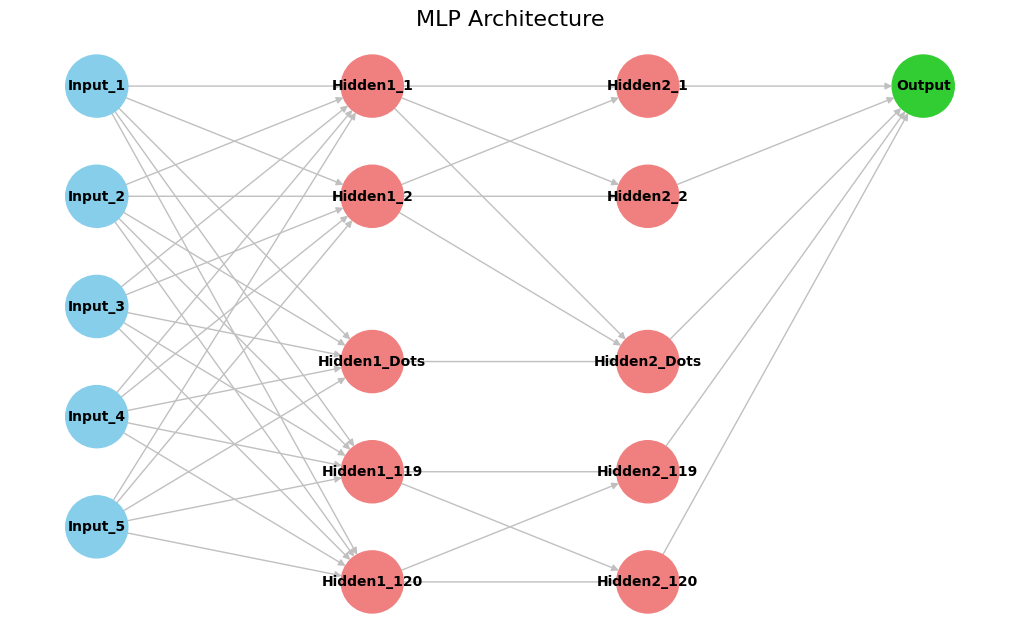

In [ ]:
#Plot to visualize the MLP architecture
def plot_mlp_full_connections(input_size, hidden_size, output_size=1):
    G = nx.DiGraph()
    pos = {}

    # Input Layer
    for i in range(input_size):
        G.add_node(f'Input_{i+1}', layer='Input')
        pos[f'Input_{i+1}'] = (0, -i)

    # Hidden Layer 1
    for i in range(2):  # Show only the first two nodes
        G.add_node(f'Hidden1_{i+1}', layer='Hidden1')
        pos[f'Hidden1_{i+1}'] = (1, -i)
    G.add_node('Hidden1_Dots', layer='Hidden1')  # Add dots to show continuity
    pos['Hidden1_Dots'] = (1, -2.5)
    G.add_node(f'Hidden1_{hidden_size - 1}', layer='Hidden1')  # Second-to-last node
    pos[f'Hidden1_{hidden_size - 1}'] = (1, -3.5)
    G.add_node(f'Hidden1_{hidden_size}', layer='Hidden1')  # Last node
    pos[f'Hidden1_{hidden_size}'] = (1, -4.5)

    # Hidden Layer 2
    for i in range(2):  # Show only the first two nodes
        G.add_node(f'Hidden2_{i+1}', layer='Hidden2')
        pos[f'Hidden2_{i+1}'] = (2, -i)
    G.add_node('Hidden2_Dots', layer='Hidden2')  # Add dots to show continuity
    pos['Hidden2_Dots'] = (2, -2.5)
    G.add_node(f'Hidden2_{hidden_size - 1}', layer='Hidden2')  # Second-to-last node
    pos[f'Hidden2_{hidden_size - 1}'] = (2, -3.5)
    G.add_node(f'Hidden2_{hidden_size}', layer='Hidden2')  # Last node
    pos[f'Hidden2_{hidden_size}'] = (2, -4.5)

    # Output Layer
    G.add_node('Output', layer='Output')
    pos['Output'] = (3, 0)

    # Edges between Input Layer and Hidden Layer 1
    for i in range(input_size):
        for j in range(2):  # Connect first two nodes
            G.add_edge(f'Input_{i+1}', f'Hidden1_{j+1}')
        G.add_edge(f'Input_{i+1}', 'Hidden1_Dots')
        G.add_edge(f'Input_{i+1}', f'Hidden1_{hidden_size - 1}')
        G.add_edge(f'Input_{i+1}', f'Hidden1_{hidden_size}')

    # Edges between Hidden Layer 1 and Hidden Layer 2
    for i in range(2):  # First two nodes
        for j in range(2):
            G.add_edge(f'Hidden1_{i+1}', f'Hidden2_{j+1}')
        G.add_edge(f'Hidden1_{i+1}', 'Hidden2_Dots')
    G.add_edge('Hidden1_Dots', 'Hidden2_Dots')  # Dots connection
    for i in [hidden_size - 1, hidden_size]:  # Last two nodes
        G.add_edge(f'Hidden1_{i}', f'Hidden2_{hidden_size - 1}')
        G.add_edge(f'Hidden1_{i}', f'Hidden2_{hidden_size}')

    # Edges between Hidden Layer 2 and Output Layer
    for i in range(2):  # First two nodes
        G.add_edge(f'Hidden2_{i+1}', 'Output')
    G.add_edge('Hidden2_Dots', 'Output')  # Dots to output
    for i in [hidden_size - 1, hidden_size]:  # Last two nodes
        G.add_edge(f'Hidden2_{i}', 'Output')

   # Assign colors to nodes
    node_colors = []
    for node in G.nodes():
        if 'Input' in node:
            node_colors.append('skyblue')  # Input nodes in skyblue
        elif 'Hidden1' in node or 'Hidden2' in node:
            node_colors.append('lightcoral')  # Hidden nodes in light coral
        elif 'Output' in node:
            node_colors.append('limegreen')  # Output node in lime green

    # Plot the graph
    plt.figure(figsize=(10, 6))
    nx.draw(
        G, pos, with_labels=True, node_size=2000, font_size=10,
        node_color=node_colors, edge_color="silver", font_weight="bold"
    )
    plt.title("MLP Architecture", fontsize=16)
    plt.show()


plot_mlp_full_connections(input_size=lags, hidden_size=hidden_size)

### Optimizing the Model Parameters

This code optimizes the Multilayer perceptron model by analyzing performance across different lag configurations.
For each lag configuration, the data is divided into a training set (80% of the data) and a test set (20%).
The training set is further split using **TimeSeriesSplit**. Each split expands the training set incrementally while reserving the next portion as a validation set. The model is trained using the **Adam optimizer** and **Mean Squared Error** (MSE) as the loss function.

After validation, the model is retrained on the entire training set and evaluated on the test set.

Results are visualized through two plots: the first shows a comparison between true and predicted values for each fold and lag configuration; the second shows the evolution of training and validation/test losses for each fold and lag.


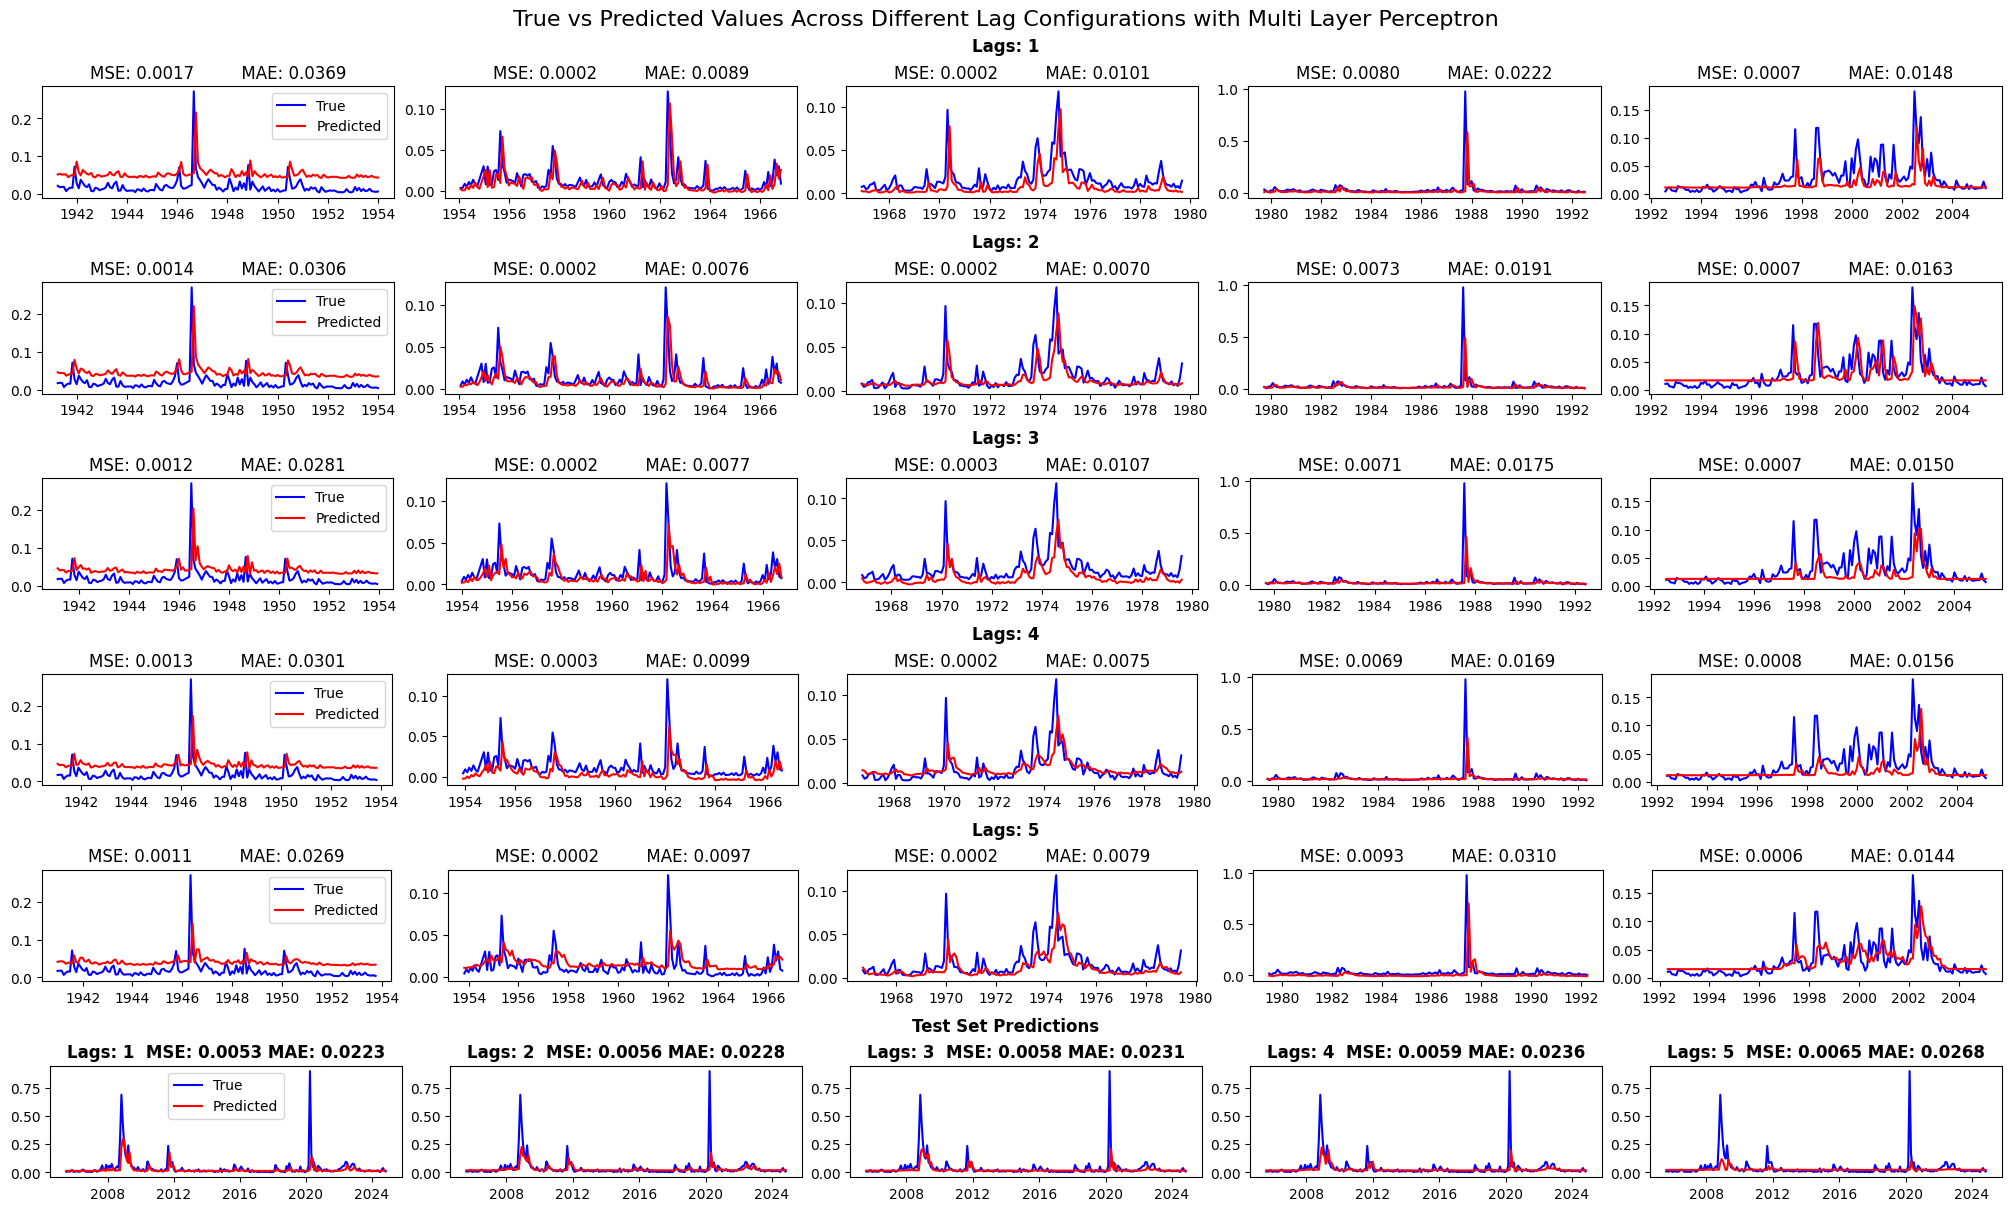

In [ ]:
# Define the loss function (Mean Squared Error)
criterion = nn.MSELoss()

fig = plt.figure(constrained_layout=True, figsize=(20, 12))
fig.suptitle('True vs Predicted Values Across Different Lag Configurations with Multi Layer Perceptron', fontsize=16)

# Create subfigures for each lag configuration row, plus one extra row for test set predictions
subfigs = fig.subfigures(nrows=len(lags_list) + 1, ncols=1)

# Select the last subfigure for test set predictions and set its title
test_subfig = subfigs[-1]
test_subfig.suptitle("Test Set Predictions", fontsize=12, fontweight='bold')

# Split the test subfigure into multiple columns, one for each lag configuration
test_axs = test_subfig.subplots(nrows=1, ncols=len(lags_list))

# Initialize lists to store Mean Squared Error and cumulative losses
train_mse = []
val_mse = []
train_test_mse = []
test_mse = []
loss_train = 0
loss_test = 0

# Loop over lag configurations, creating one row per lag configuration
for row, (lags, subfig) in enumerate(zip(lags_list, subfigs[:-1])):
    subfig.suptitle(f'Lags: {lags}', fontsize=12, fontweight='bold')

    # Create lagged input features (X) and target values (y) for the current lag configuration
    X, y = create_lags_array(monthly_RV_array, lags)

    # Split the dataset into training and test sets
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=shuffle)

    # Initialize TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Create subplots for cross-validation within the current subfigure
    axs = subfig.subplots(nrows=1, ncols=n_splits)

    # Initialize the Multi-Layer Perceptron model for the current lag configuration
    model = MLP(lags, hidden_size)

    # Loop over each cross-validation split
    for i, (train, val) in enumerate(tscv.split(train_X)):
        # Create a fresh copy of the model for each fold
        model_2 = deepcopy(model)

        # Initialize the Adam optimizer
        optimizer = torch.optim.Adam(model_2.parameters(), lr=lr)

        # Prepare training data and target tensors for the current fold
        data_tensor = torch.tensor(train_X[train, :], dtype=torch.float32)
        target_tensor = torch.tensor(train_y[train], dtype=torch.float32)

        # Combine input and target tensors into a TensorDataset
        dataset = TensorDataset(data_tensor, target_tensor)

        # Create a DataLoader for batch processing during training
        dataloader = DataLoader(dataset, batch_size=32, shuffle=shuffle)

        # Set the model to training mode
        model_2.train()

        # Initialize lists to store MSE for training and validation for each epoch
        epoch_train_mse = []
        epoch_val_mse = []

        # Training loop over epochs
        for _ in range(epochs):
            loss_train = 0  # Reset training loss for the current epoch

            # Loop through batches in the DataLoader
            for batch_idx, (data, target) in enumerate(dataloader):
                optimizer.zero_grad()  # Reset gradients
                output = model_2(data)  # Forward pass
                loss = criterion(output.squeeze(), target)  # Compute training loss
                loss_train += loss.item()  # Accumulate loss
                loss.backward()  # Backpropagation
                optimizer.step()  # Update model parameters

            # Compute and store the average training loss for the epoch
            epoch_train_mse.append(loss_train / len(dataloader))

            # Validation: evaluate the model on the validation set without computing gradients
            with torch.no_grad():
                y_predict = model_2(torch.FloatTensor(train_X[val, :])).squeeze()
                loss_test = criterion(y_predict, torch.FloatTensor(train_y[val])).item()
                epoch_val_mse.append(loss_test)

        # Append training and validation MSE for this fold
        train_mse.append(epoch_train_mse)
        val_mse.append(epoch_val_mse)

        # Predict on the validation set for plotting
        y_predict = model_2(torch.FloatTensor(train_X[val, :])).detach().numpy()

        # Plot true vs predicted values for the validation fold
        axs[i].plot(dates[val], train_y[val], color="blue", label="True")
        axs[i].plot(dates[val], y_predict, color="red", label="Predicted")
        axs[i].set_title(f'MSE: {mean_squared_error(y_predict, train_y[val]):.4f} \
        MAE: {mean_absolute_error(y_predict, train_y[val]):.4f}')

        # Add a legend for the first subplot in the row
        if i == 0:
            axs[i].legend()

    # Train the model on the entire training data
    data_tensor = torch.tensor(train_X, dtype=torch.float32)
    target_tensor = torch.tensor(train_y, dtype=torch.float32)

    # Initialize the optimizer and DataLoader
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    dataset = TensorDataset(data_tensor, target_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=shuffle)

    # Set the model to training mode
    model.train()

    # Initialize lists to store training and test MSE for each epoch
    epoch_train_mse = []
    epoch_test_mse = []

    # Training loop over epochs
    for _ in range(epochs):
        loss_train = 0  # Reset training loss for the epoch

        # Training on batches
        for batch_idx, (data, target) in enumerate(dataloader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output.squeeze(), target)
            loss_train += loss.item()
            loss.backward()
            optimizer.step()

        # Compute average training loss for the epoch
        epoch_train_mse.append(loss_train / len(dataloader))

        # Test set evaluation
        with torch.no_grad():
            y_predict = model(torch.FloatTensor(test_X))
            loss_test = criterion(y_predict.squeeze(), torch.FloatTensor(test_y)).item()
            epoch_test_mse.append(loss_test)

    # Append training and test MSE for the model trained on full training set
    train_test_mse.append(epoch_train_mse)
    test_mse.append(epoch_test_mse)

    # Predict on the test set for plotting
    y_predict = model(torch.FloatTensor(test_X)).detach().numpy()

    # Plot true vs predicted values for the test set
    test_axs[row].plot(dates[-len(test_X):], test_y, color="blue", label="True")
    test_axs[row].plot(dates[-len(test_X):], y_predict, color="red", label="Predicted")
    test_axs[row].set_title(
        f'Lags: {lags}  MSE: {mean_squared_error(y_predict, test_y):.4f} '
        f'MAE: {mean_absolute_error(y_predict, test_y):.4f}', fontweight='bold'
    )

    # Add a legend only for the first subplot in the test set row
    if row == 0:
        test_axs[row].legend()

plt.show()

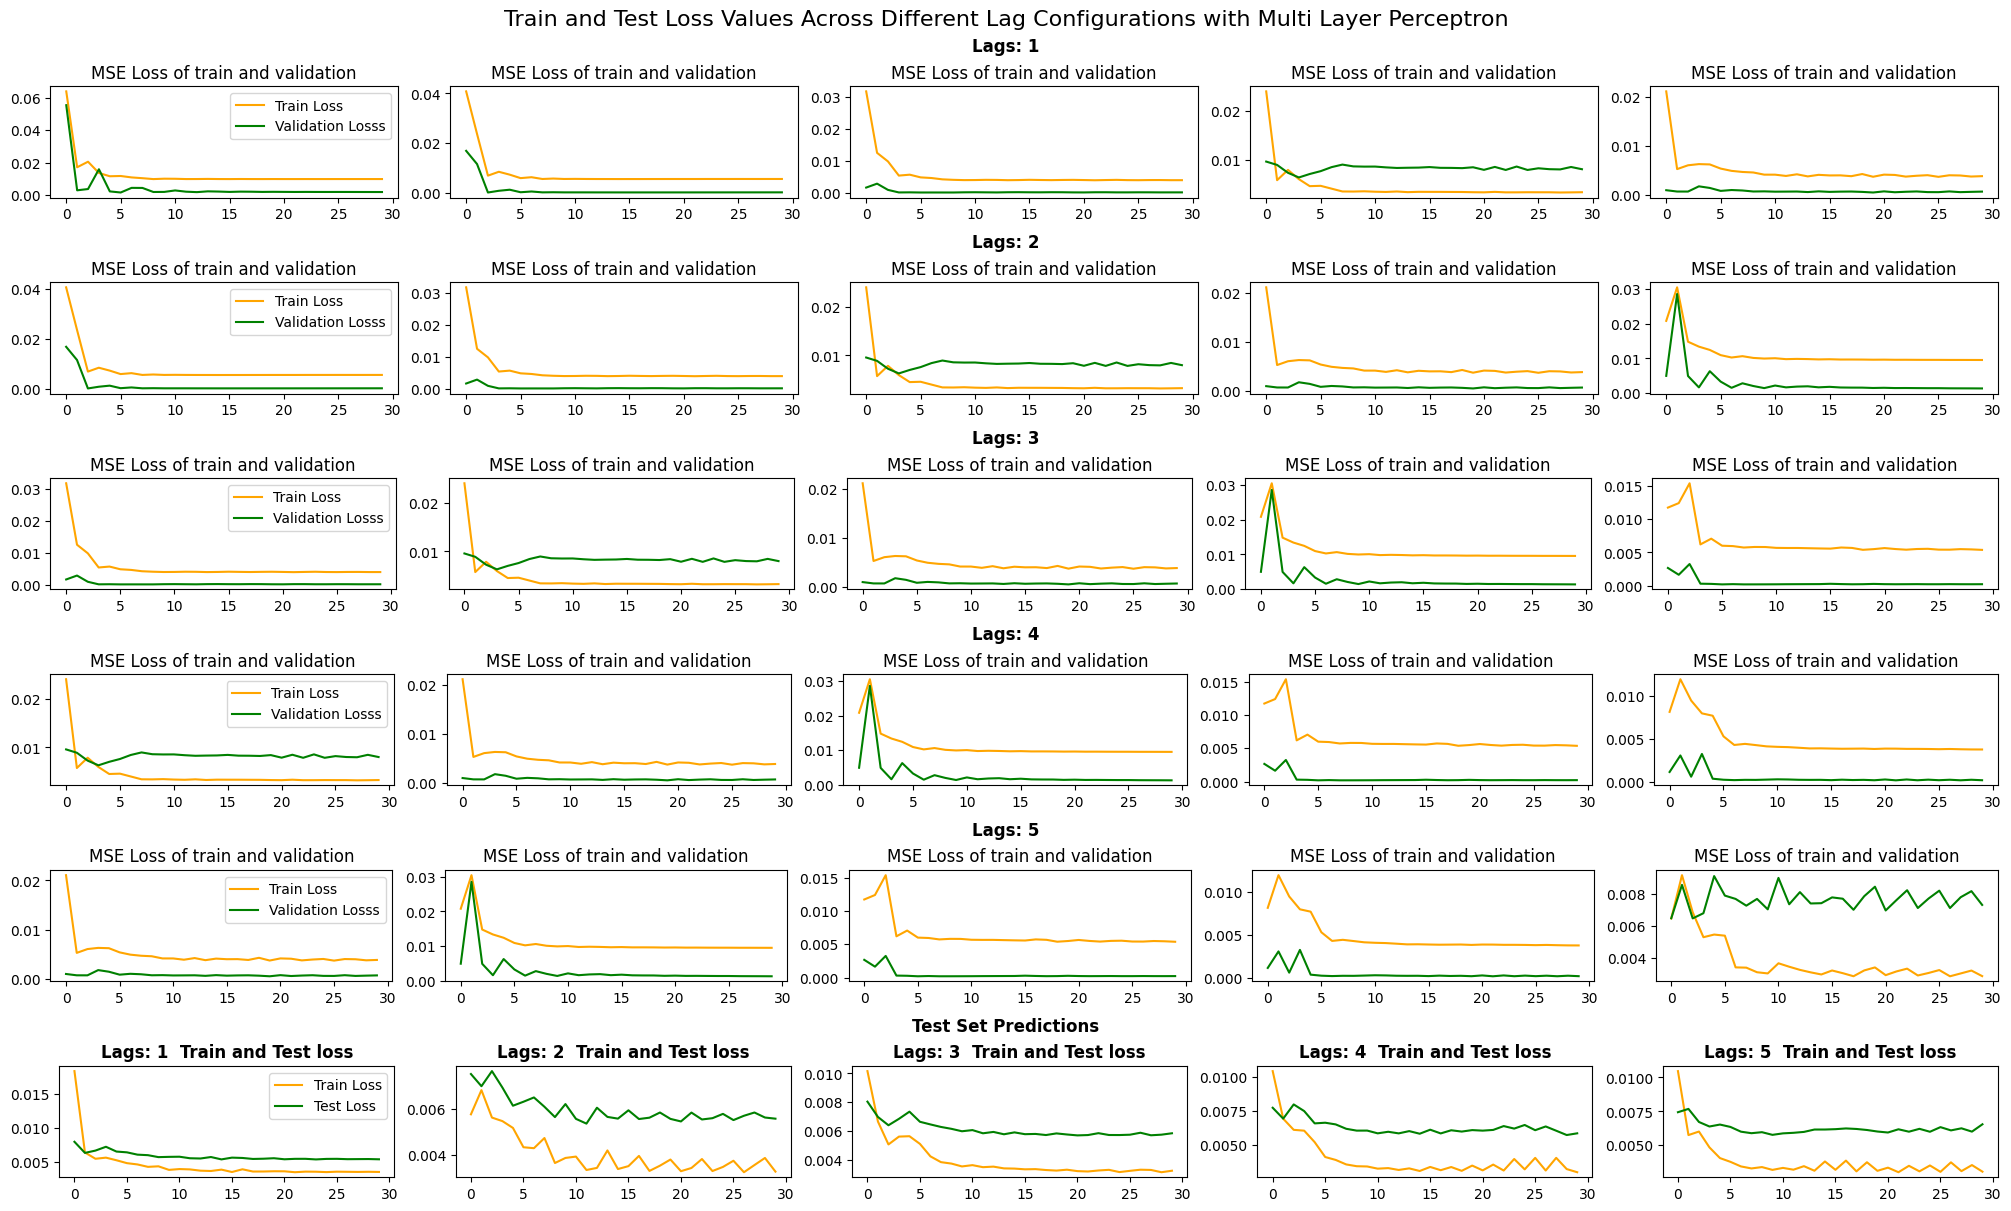

In [ ]:
# This code generates plots for train, validation, and test loss across different lag configurations.
# Each row corresponds to a specific lag configuration with subplots for cross-validation splits.
# The final row shows train and test loss for the entire dataset.
fig = plt.figure(constrained_layout=True, figsize=(20, 12))
fig.suptitle('Train and Test Loss Values Across Different Lag Configurations with Multi Layer Perceptron', fontsize=16)

subfigs = fig.subfigures(nrows=len(lags_list) + 1, ncols=1)

test_subfig = subfigs[-1]
test_subfig.suptitle("Test Set Predictions", fontsize=12, fontweight='bold')
test_axs = test_subfig.subplots(nrows=1, ncols=len(lags_list))

for row, (lags, subfig) in enumerate(zip(lags_list, subfigs[:-1])):
    subfig.suptitle(f'Lags: {lags}', fontsize=12, fontweight='bold')
    axs = subfig.subplots(nrows=1, ncols=n_splits)
    for i in range(n_splits):
        axs[i].plot(range(epochs), train_mse[row + i], color="orange", label="Train Loss")
        axs[i].plot(range(epochs), val_mse[row + i], color="green", label="Validation Losss")
        axs[i].set_title(f'MSE Loss of train and validation')

        if i == 0:
            axs[i].legend()

    test_axs[row].plot(range(epochs), train_test_mse[row], color="orange", label="Train Loss")
    test_axs[row].plot(range(epochs), test_mse[row], color="green", label="Test Loss")
    test_axs[row].set_title(f'Lags: {lags}  Train and Test loss', fontweight='bold')
    if row == 0:
      test_axs[row].legend()
plt.show()

### Results

The results show that the MLP model performs well across different lag configurations, as seen in the alignment between true and predicted values and the smooth convergence of train, validation, and test losses. Lower lag configurations (e.g., Lags 1 and 2) have better performance, with low MSE and MAE, and minimal divergence between training and validation/test losses. For higher lags, like Lags 4 and 5, the performance is less consistent, with more variation in losses and predictions, suggesting increased complexity.


# Comparison between the three models to select the best one.

Now we will evaluate the performance of three models: Linear Regression, Decision Tree, and MLP on time-series regression, examine the influence of varying lag configurations on prediction accuracy, and visualize the models' predictions alongside the true values.

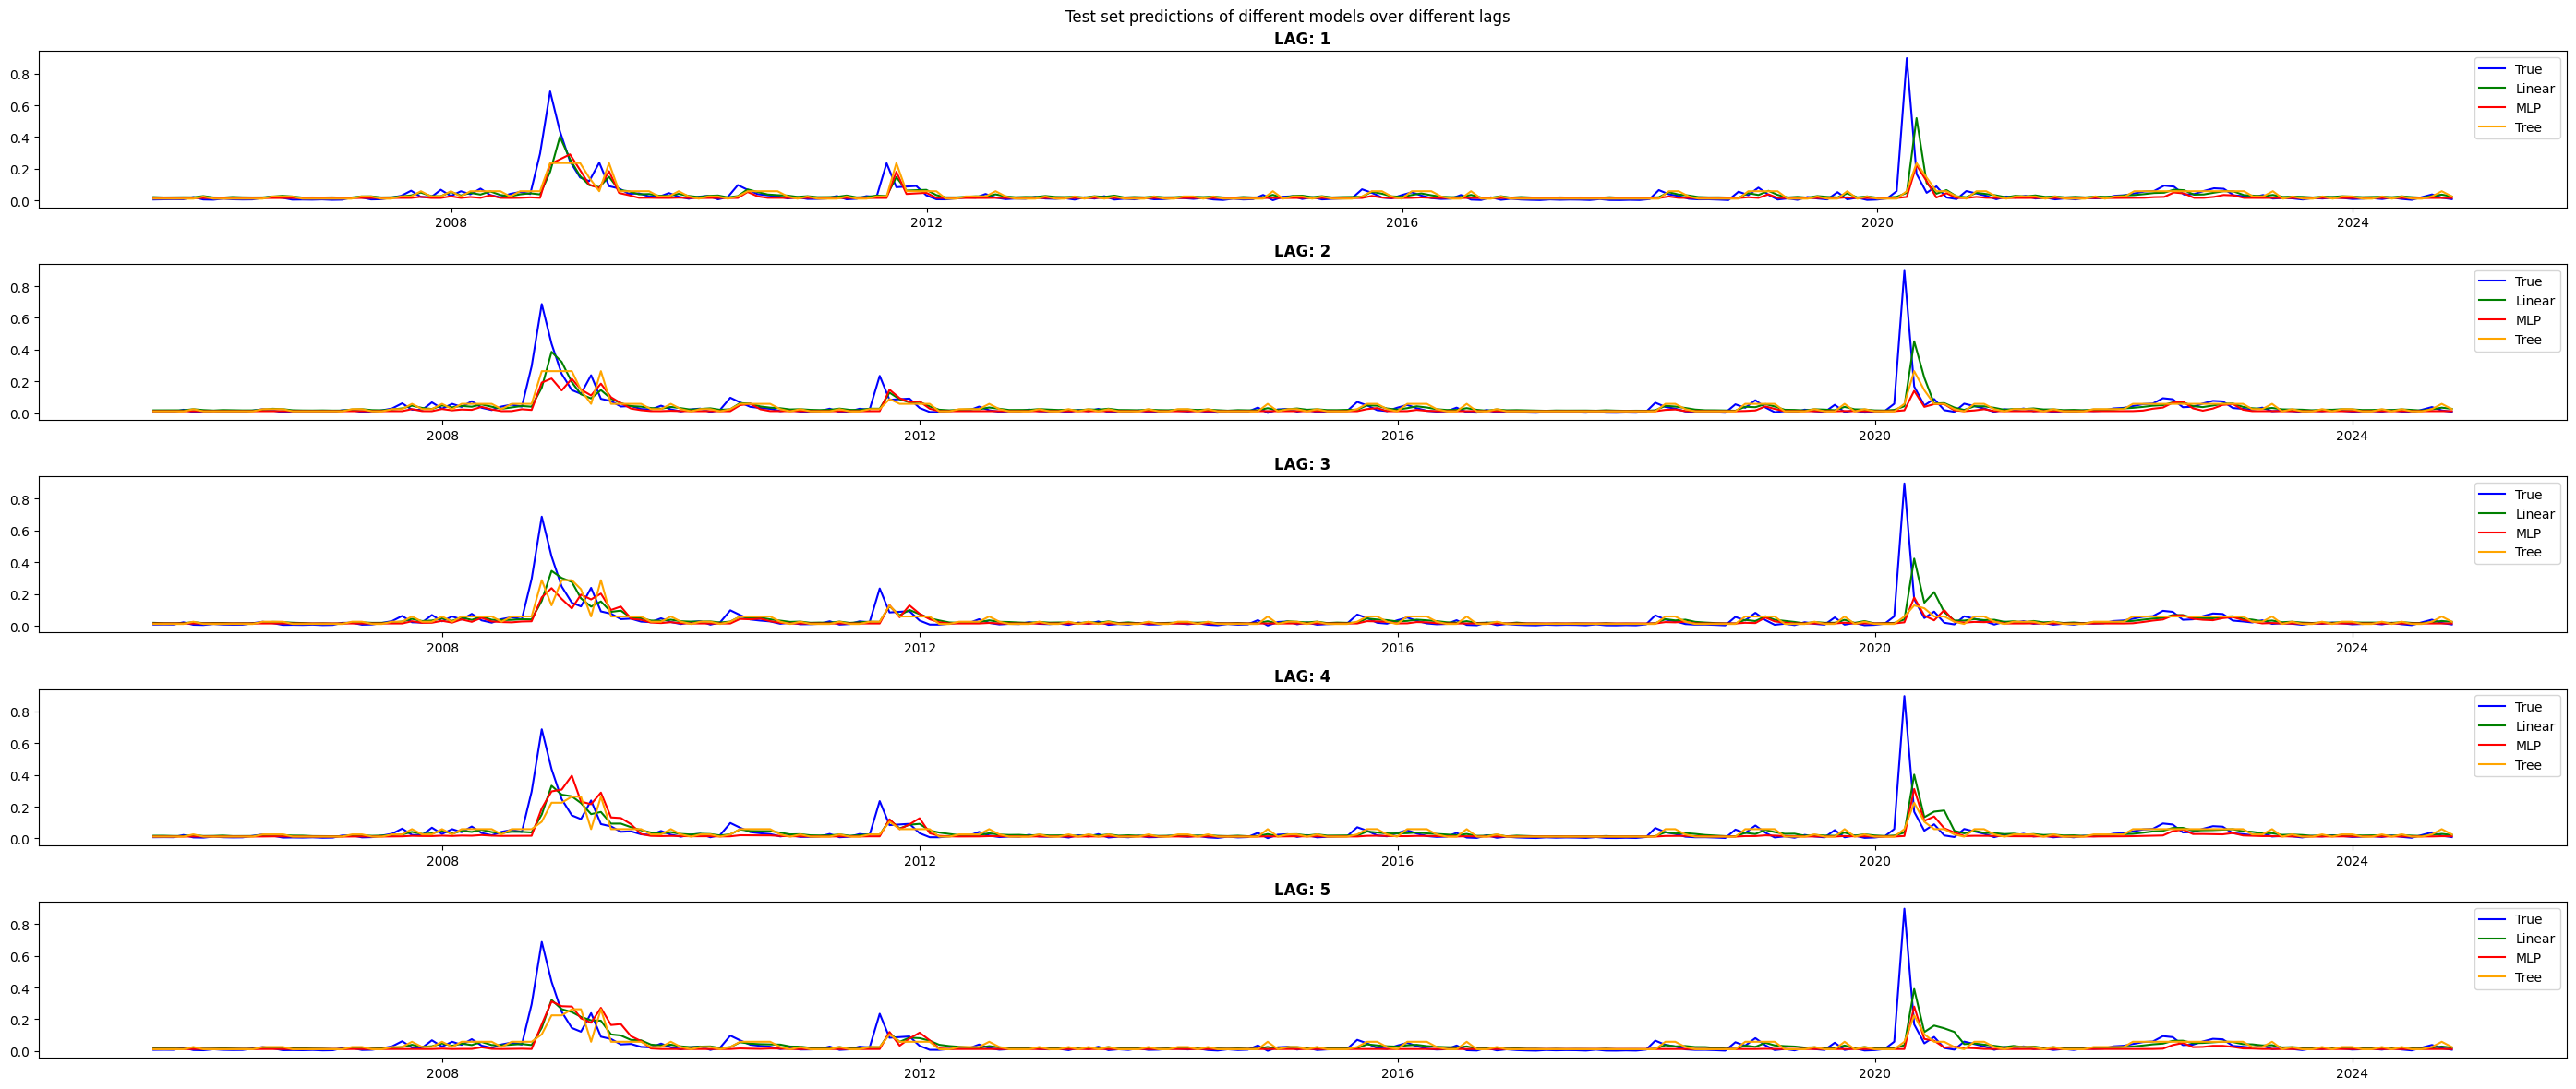

In [ ]:
tree_mse_loss = [] #Store Mean Squared Error
linear_mse_loss = []
mlp_mse_loss = []

tree_mae_loss = [] #Store Mean Absolute Error
linear_mae_loss = []
mlp_mae_loss = []

predicted_mlp = [] #Store predictions from each model for the most recent lag configuration
predicted_linear = []
predicted_tree = []

fig, axs = plt.subplots(len(lags_list), 1, figsize=(28, 12))
fig.suptitle('Test set predictions of different models over different lags')

for i, lags in enumerate(lags_list):
    X, y = create_lags_array(monthly_RV_array, lags)
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=shuffle) #Splits the data into training and testing sets
    clf.fit(train_X, train_y) #Trains the linear regression model on the same data
    tree_regressor.fit(train_X, train_y) #Trains the decision tree regressor using the training data
    data_tensor = torch.tensor(train_X, dtype=torch.float32)
    target_tensor = torch.tensor(train_y, dtype=torch.float32)  # Use long for classification labels
    model = MLP(lags, hidden_size) #creates an MLP model
    optimizer = torch.optim.Adam(
        model.parameters(), lr=lr
    )
    # Use TensorDataset to combine data and target tensors
    dataset = TensorDataset(data_tensor, target_tensor)
    # Create a DataLoader with the TensorDataset
    dataloader = DataLoader(dataset, batch_size=32, shuffle=shuffle) #create batches of data for efficient training
    model.train()  # Set model to training mode
    for _ in range(epochs):
        for batch_idx, (data, target) in enumerate(dataloader):
            optimizer.zero_grad()  # Reset gradients to zero
            output = model(data)  # Get model output for training set
            loss = criterion(output.squeeze(), target)  # Calculate the training loss (loss function)
            loss.backward()  # Backpropagate to compute gradients
            optimizer.step()  # Update model weights
    #Predictions
    y_predict_mlp = model(torch.FloatTensor(test_X)).detach().numpy()
    y_predict_linear = clf.predict(test_X)
    y_predict_tree = tree_regressor.predict(test_X)
    #Visualize the predictions
    axs[i].set_title(f"LAG: {lags}", fontweight = "bold")
    axs[i].plot(dates[-len(test_X):], test_y, color="blue", label="True")
    axs[i].plot(dates[-len(test_X):], y_predict_linear, color="green",
    label="Linear")
    axs[i].plot(dates[-len(test_X):], y_predict_mlp, color="red",
    label="MLP")
    axs[i].plot(dates[-len(test_X):], y_predict_tree, color="orange",
    label="Tree")
    axs[i].legend()

    #Calculates and stores performance metrics for each model on the test set
    tree_mse_loss.append(mean_squared_error(y_predict_tree, test_y))
    linear_mse_loss.append(mean_squared_error(y_predict_linear, test_y))
    mlp_mse_loss.append(mean_squared_error(y_predict_mlp, test_y))

    tree_mae_loss.append(mean_absolute_error(y_predict_tree, test_y))
    linear_mae_loss.append(mean_absolute_error(y_predict_linear, test_y))
    mlp_mae_loss.append(mean_absolute_error(y_predict_mlp, test_y))

    #Calculate future predictions

    x = X[-1].reshape(-1,1).T #For the most recent lag configuration

    y_predict_mlp = model(torch.FloatTensor(x)).detach().numpy() #Generates predictions from each model
    y_predict_linear = clf.predict(x)
    y_predict_tree = tree_regressor.predict(x)

    predicted_mlp.append(y_predict_mlp.item()) #Storing the predictions
    predicted_linear.append(y_predict_linear.item())
    predicted_tree.append(y_predict_tree.item())


plt.tight_layout()
plt.show()

We will now consolidate error metrics into structured tables for easy comparison.

Highlight the model that performs best for each lag configuration based on both MSE and MAE.

Provide a clear overview of which model is most suitable for a given lag configuration.

In [ ]:
#Dataframes are created to store error metrics for each lag configuration
loss_mse_df = pd.DataFrame(data={"Lags" : np.arange(min_lags,max_lags+1),
                                 "Tree" : tree_mse_loss, "MLP": mlp_mse_loss,
                                 "Linear":linear_mse_loss})
loss_mae_df = pd.DataFrame(data={"Lags" : np.arange(min_lags,max_lags+1),
                                 "Tree" : tree_mae_loss, "MLP": mlp_mae_loss,
                                 "Linear":linear_mae_loss})
#The winner column is added to each Dataframe
loss_mse_df["Winner"] = loss_mse_df.idxmin(axis=1)
loss_mae_df["Winner"] = loss_mae_df.idxmin(axis=1)

print("Mean squared errors")
display(loss_mse_df)
print("Mean absolute error")
display(loss_mae_df)

Mean squared errors


,Lags,Tree,MLP,Linear,Winner
0,1,0.005299,0.005453,0.005650,Tree
1,2,0.005155,0.005659,0.005731,Tree
2,3,0.005424,0.005607,0.005762,Tree
3,4,0.005943,0.006125,0.005826,Linear
4,5,0.005943,0.006027,0.005803,Linear


Mean absolute error


,Lags,Tree,MLP,Linear,Winner
0,1,0.025566,0.023290,0.024928,MLP
1,2,0.025173,0.022811,0.025020,MLP
2,3,0.026097,0.023033,0.025381,MLP
3,4,0.026284,0.025484,0.025511,MLP
4,5,0.026283,0.025437,0.025361,Linear


As we can see, the two types of errors are consistent with each other. By including the mean absolute return, we aimed to ensure that the errors remained significant and meaningful for evaluation.

Also, as the number of lags increases, the errors tend to grow, making fewer lags more desirable for accurate predictions.

All three models demonstrate low errors and produce similar results, which is why we chose to keep all of them.

We now revert the errors to the original scale of realized variance, allowing for direct comparison with the true values. The plot highlights the model's predictions alongside the true realized variance.

In [ ]:
predicted_realized_variance = pd.DataFrame(data={"Lags" : np.arange(1,5+1),"Tree" : predicted_tree, "MLP": predicted_mlp, "Linear": predicted_linear})
predicted_realized_variance #Each column contains the predicted realized variance for the respective model for the corresponding lag configuration

,Lags,Tree,MLP,Linear
0,1,0.025703,0.016088,0.025503
1,2,0.025565,0.013115,0.027352
2,3,0.025565,0.014645,0.024840
3,4,0.025576,0.013624,0.022377
4,5,0.025572,0.012788,0.021480


Now we take the difference between each model’s realized variance prediction ($E^P_t[RV_{1M}]$) and the $VIX^2$ ($E^Q_t[RV_{1M}]$).

This difference represents the "variance risk premium" ($VRP_{1M}$) and the opposite of the $VRP_{1m}$ is the expected compensation for selling one-month variance swaps.

In [ ]:
variance_risk_premium = predicted_realized_variance.iloc[:, 1:].values - close_VIX.values ** 2 #we extract the predicted realized variance values for each model and we subtract vix squared

variance_risk_premium_df = pd.DataFrame({
    "Lags": [1, 2, 3, 4, 5],
    "Tree": variance_risk_premium[:, 0],
    "MLP": variance_risk_premium[:, 1],
    "Linear": variance_risk_premium[:, 2]
})

variance_risk_premium_df

,Lags,Tree,MLP,Linear
0,1,-0.022170,-0.031785,-0.022371
1,2,-0.022308,-0.034758,-0.020521
2,3,-0.022308,-0.033228,-0.023033
3,4,-0.022297,-0.034250,-0.025497
4,5,-0.022302,-0.035086,-0.026393


As observed from our models, the variance risk premium is negative. This suggests that, no matter the model used, selling variance swap would result in a profit for the month of November.

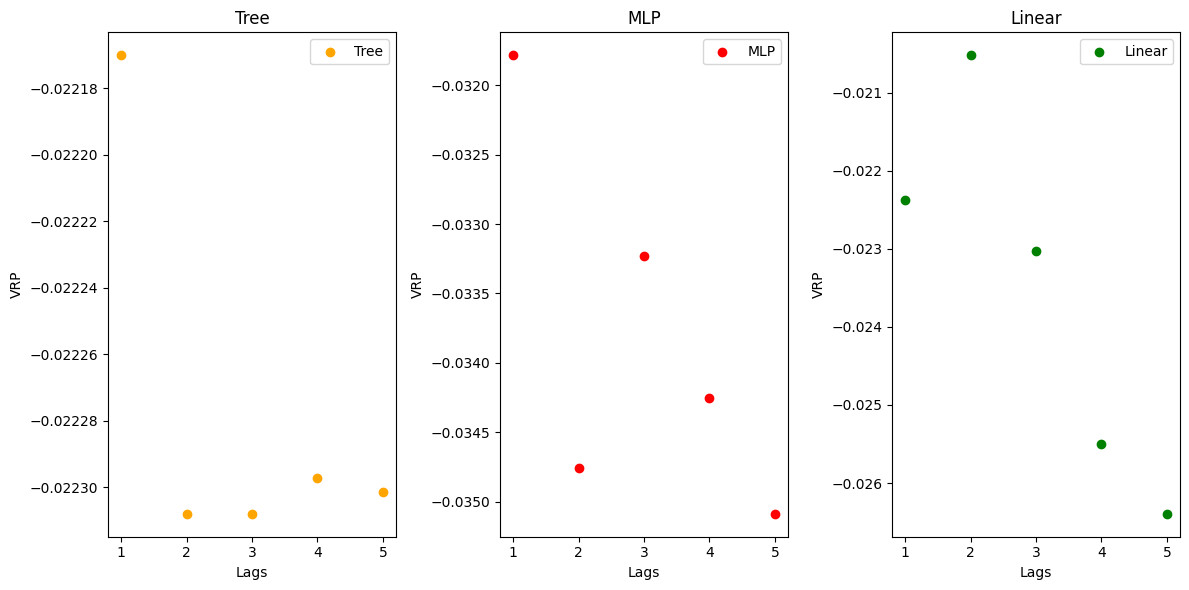

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
colors = ['orange', 'red', 'green']

for i, column in enumerate(["Tree", "MLP", "Linear"]):
    axs[i].scatter(
        x=variance_risk_premium_df["Lags"].values,
        y=variance_risk_premium_df[column].values,
        color=colors[i],
        label=column
    )
    axs[i].set_title(column)
    axs[i].set_xlabel("Lags")
    axs[i].set_ylabel("VRP")
    axs[i].legend()

plt.tight_layout()
plt.show()

As shown in the final plot, the Decision Tree exhibits the lowest variance, while the Multilayer Perceptron has the highest due to its greater complexity. The Linear Regression, being the simplest model, strikes a balance by offering a favorable trade-off.

#Conclusion


To conclude, all three models show similar performance, with Decision Tree and Linear Regression achieving the lowest error rates in terms of Mean Squared Error. However, the Multilayer Perceptron performs slightly better for Mean Absolute Error.

Given how close the results are, we refrain from declaring a definitive "best" model and instead choose to analyze all of them further. That said, if the problem demands handling greater complexity or capturing non-linear relationships, the Multilayer Perceptron would be the preferred choice.

From an interpretative point of view, in all three models the variance risk premium is negative, suggesting that selling variance swaps should be profitable and therefore we should sell these contracts.